In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Formatting Examples

In [3]:
orig = pd.read_csv('origCode.mutex', delimiter=' ', header=None)
orig = orig.drop(orig.columns[-1], axis=1).dropna() # Extra NaN column for some reason (and dropna for issue fix)
orig # 0 0 indicates no error, anything else indicates error

,0,1
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2506269,0,0
2506270,0,0
2506271,0,0
2506272,0,0


In [5]:
fails = orig[(orig != 0).any(axis=1)]
pd.set_option('display.max_rows', None)
fails # Maybe all errors are 1 0?

,0,1
626592,1,0
667731,1,0
675851,1,0
684705,1,0
688179,1,0
768173,1,0
773167,1,0
795216,1,0
830021,1,0
844343,1,0


In [6]:
len(fails) / len(orig) # Error rate for a sample

1.7954940281868624e-05

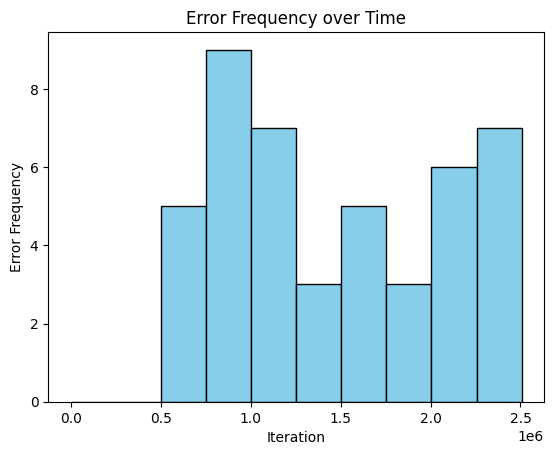

In [7]:
plt.hist(fails.index, color='skyblue', edgecolor='black', range=(0, len(orig)))
plt.xlabel('Iteration')
plt.ylabel('Error Frequency')
plt.title('Error Frequency over Time')
plt.show()

## Errors with respect to iteration

In [8]:
def plot_error_freq_time(file_name, title, subplot, drop=False):
    data = pd.read_csv(file_name, delimiter=' ', header=None)
    data = data.drop(data.columns[-1], axis=1)
    if drop:
        data = data.dropna()
    errors = data[(data != 0).any(axis=1)] # Not 0 0 (error)
    subplot.hist(errors.index, range=(0, len(data)), edgecolor='black')
    subplot.set_title(title)
    subplot.set_xlabel('Iteration')
    subplot.set_ylabel('Errors')

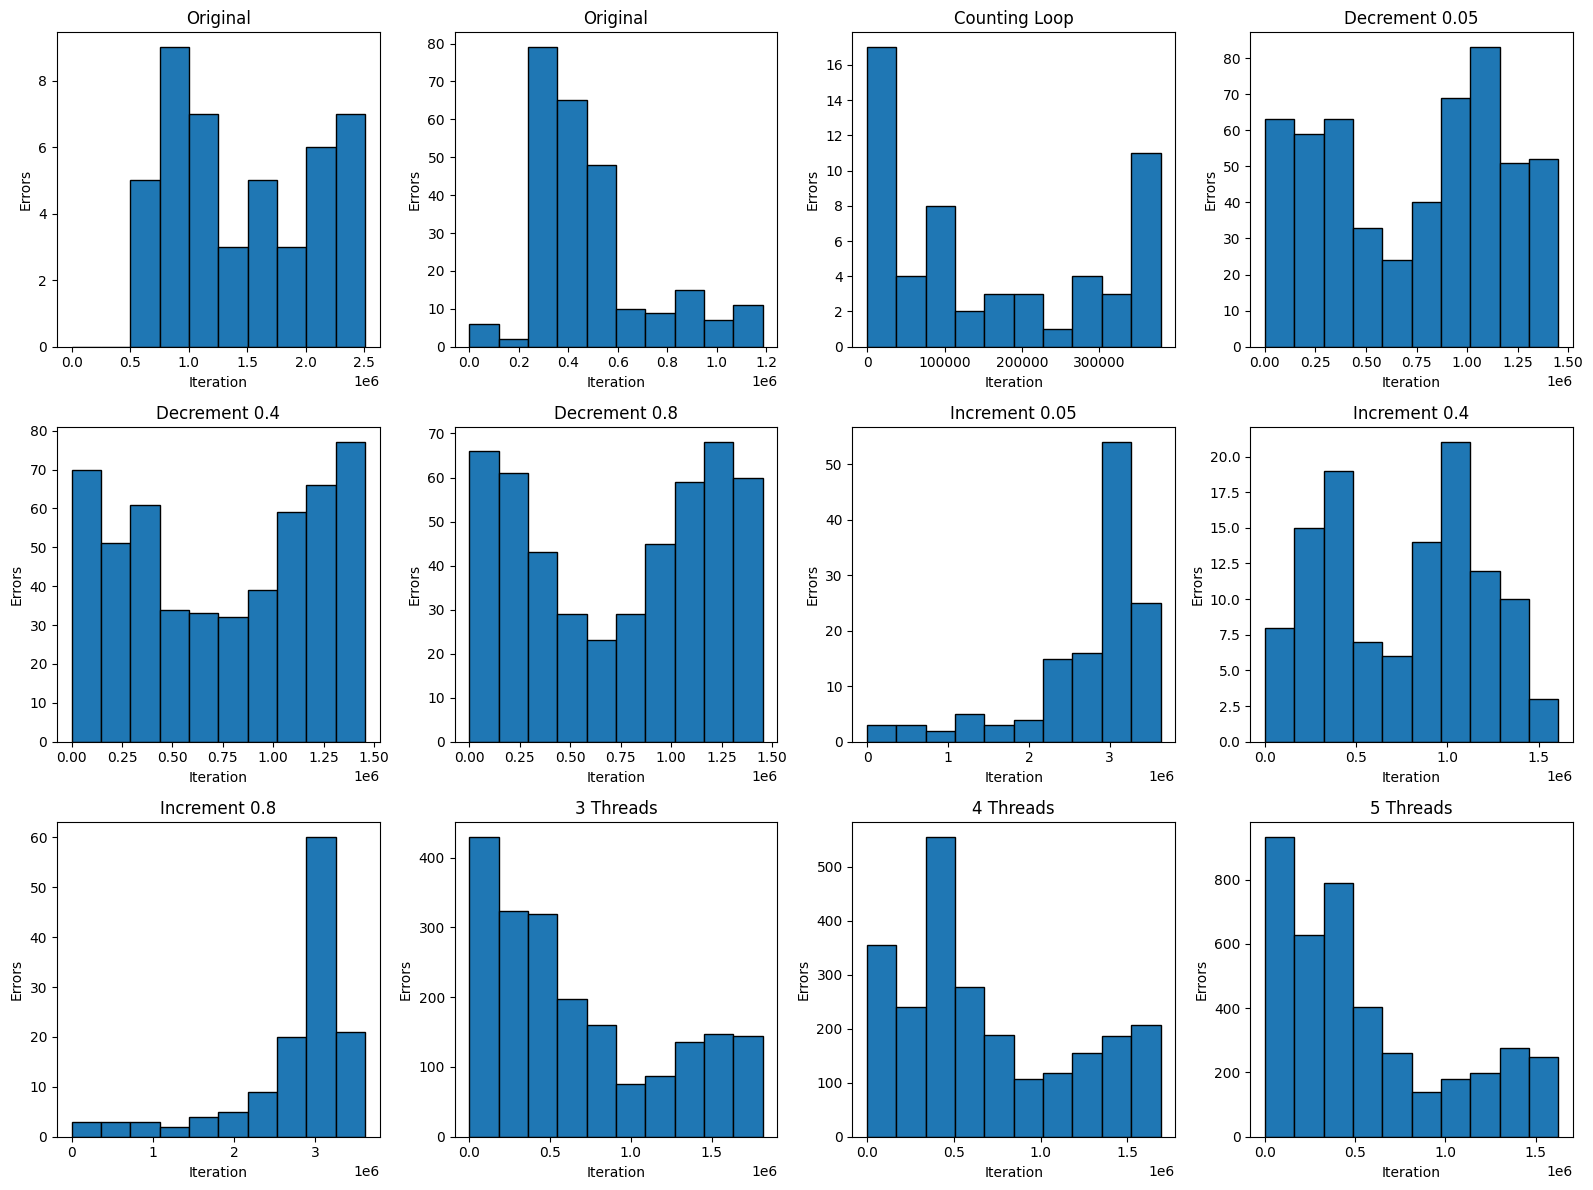

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12))
axs = axs.flatten()

plot_error_freq_time('origCode.mutex', 'Original', axs[0]) # Inc. Section Sleep = 0.1, Dec. Section Sleep = 0.2, Threads = 2
plot_error_freq_time('sameSleep0.4.mutex', 'Original', axs[1]) # Inc. Sec. Sleep = 0.4, Dec. Sec. Sleep = 0.4, Threads = 2
# Each of the following change 1 variable from the original
plot_error_freq_time('countingLoop.mutex', 'Counting Loop', axs[2]) # Loop instead of sleep function (same variables)
plot_error_freq_time('dec0.05.mutex', 'Decrement 0.05', axs[3]) # Dec = 0.05
plot_error_freq_time('out0.4.mutex', 'Decrement 0.4', axs[4]) # Dec = 0.4
plot_error_freq_time('dec0.8.mutex', 'Decrement 0.8', axs[5]) # Dec = 0.8
plot_error_freq_time('inc0.05.mutex', 'Increment 0.05', axs[6]) # Inc = 0.05
plot_error_freq_time('inc0.4.mutex', 'Increment 0.4', axs[7]) # Inc = 0.4
plot_error_freq_time('inc0.8.mutex', 'Increment 0.8', axs[8]) # Inc = 0.8
plot_error_freq_time('out3threads.mutex', '3 Threads', axs[9]) # Threads = 3
plot_error_freq_time('out4threads.mutex', '4 Threads', axs[10], drop=True) # Threads = 4
plot_error_freq_time('out5threads.mutex', '5 Threads', axs[11], drop=True) # Threads = 5

plt.tight_layout()
plt.show()